<a href="https://colab.research.google.com/github/adamiaonr/cveml/blob/main/projects/project-001/scripts/notebooks/ei_saliency_and_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saliency and Grad-CAM Examples

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/computer-vision-with-embedded-machine-learning/blob/master/2.3.1%20-%20CNN%20Visualizations/ei_saliency_and_grad_cam.ipynb)

Import a trained model (.zip file) from Edge Impulse and copy in post-processed features of a single sample image. Run the notebook to see a saliency map and Grad-CAM heatmap.

Saliency maps highlight which pixels in the input image were most important (i.e. most salient) in the decision making process.

Grad-CAM looks at the output feature map of the final convolution layer to figure out which areas of the image were the most important in the decision making process.

Original author: EdgeImpulse, Inc.<br>
Modified by: adamiaonr@gmail.com<br>
Last modified: December 27, 2021<br>
License: [Apache-2.0](apache.org/licenses/LICENSE-2.0)<br>

In [210]:
import os
import PIL
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from keras import activations, layers, models, backend


In [305]:
### Unzip model

# folder where model will be saved
model_dir = "/content/saved_model"

# remove any previously loaded model
!rm -rf "{model_dir}"

# Change this based on your .zip model filename
model_zip_path = "/content/ei-cveml-electronic-components-cnn-tensorflow-savedmodel-model.zip"
# model_zip_path = "/content/ei-cveml-electronic-components-dnn-augmented-v2-nn-classifier-tensorflow-savedmodel-model.zip"

# Unzip in place
!unzip "{model_zip_path}"

# create directory for output figures
output_img_dir = "/content/figures"
try:
  os.makedirs(output_img_dir)
except FileExistsError:
  print("WARNING: Output directory already exists. Check to make sure it is empty.")


Archive:  /content/ei-cveml-electronic-components-cnn-tensorflow-savedmodel-model.zip
   creating: saved_model/
   creating: saved_model/assets/
   creating: saved_model/variables/
  inflating: saved_model/saved_model.pb  
  inflating: saved_model/variables/variables.data-00000-of-00001  
  inflating: saved_model/variables/variables.index  


In [306]:
### get a series of images from the sample folder, for which we'll draw saliency 
### and GRAD-CAMs (if applicable to the model type)

# image resolution
width = 28
height = 28

# labels
labels = ["background", "capacitor", "led", "resistor"]

# go through all .png in the folder, normalize to [0.0, 1.0] range and save index of true label
imgs_normalized = []
true_label_idx = []

for i, filename in enumerate(os.listdir("/content/sample-images")):

  if filename == ".ipynb_checkpoints":
    continue

  # extract features from .png image, convert to grayscale
  img = PIL.Image.open(os.path.join("/content/sample-images", filename)).convert('L')
  # appened normalized array to img array
  imgs_normalized.append(np.asarray(img) / 255.0)
  # append index of true label
  true_label_idx.append(labels.index(filename.split('-')[0]))


In [318]:
### Load model file
model = tf.keras.models.load_model(model_dir)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0

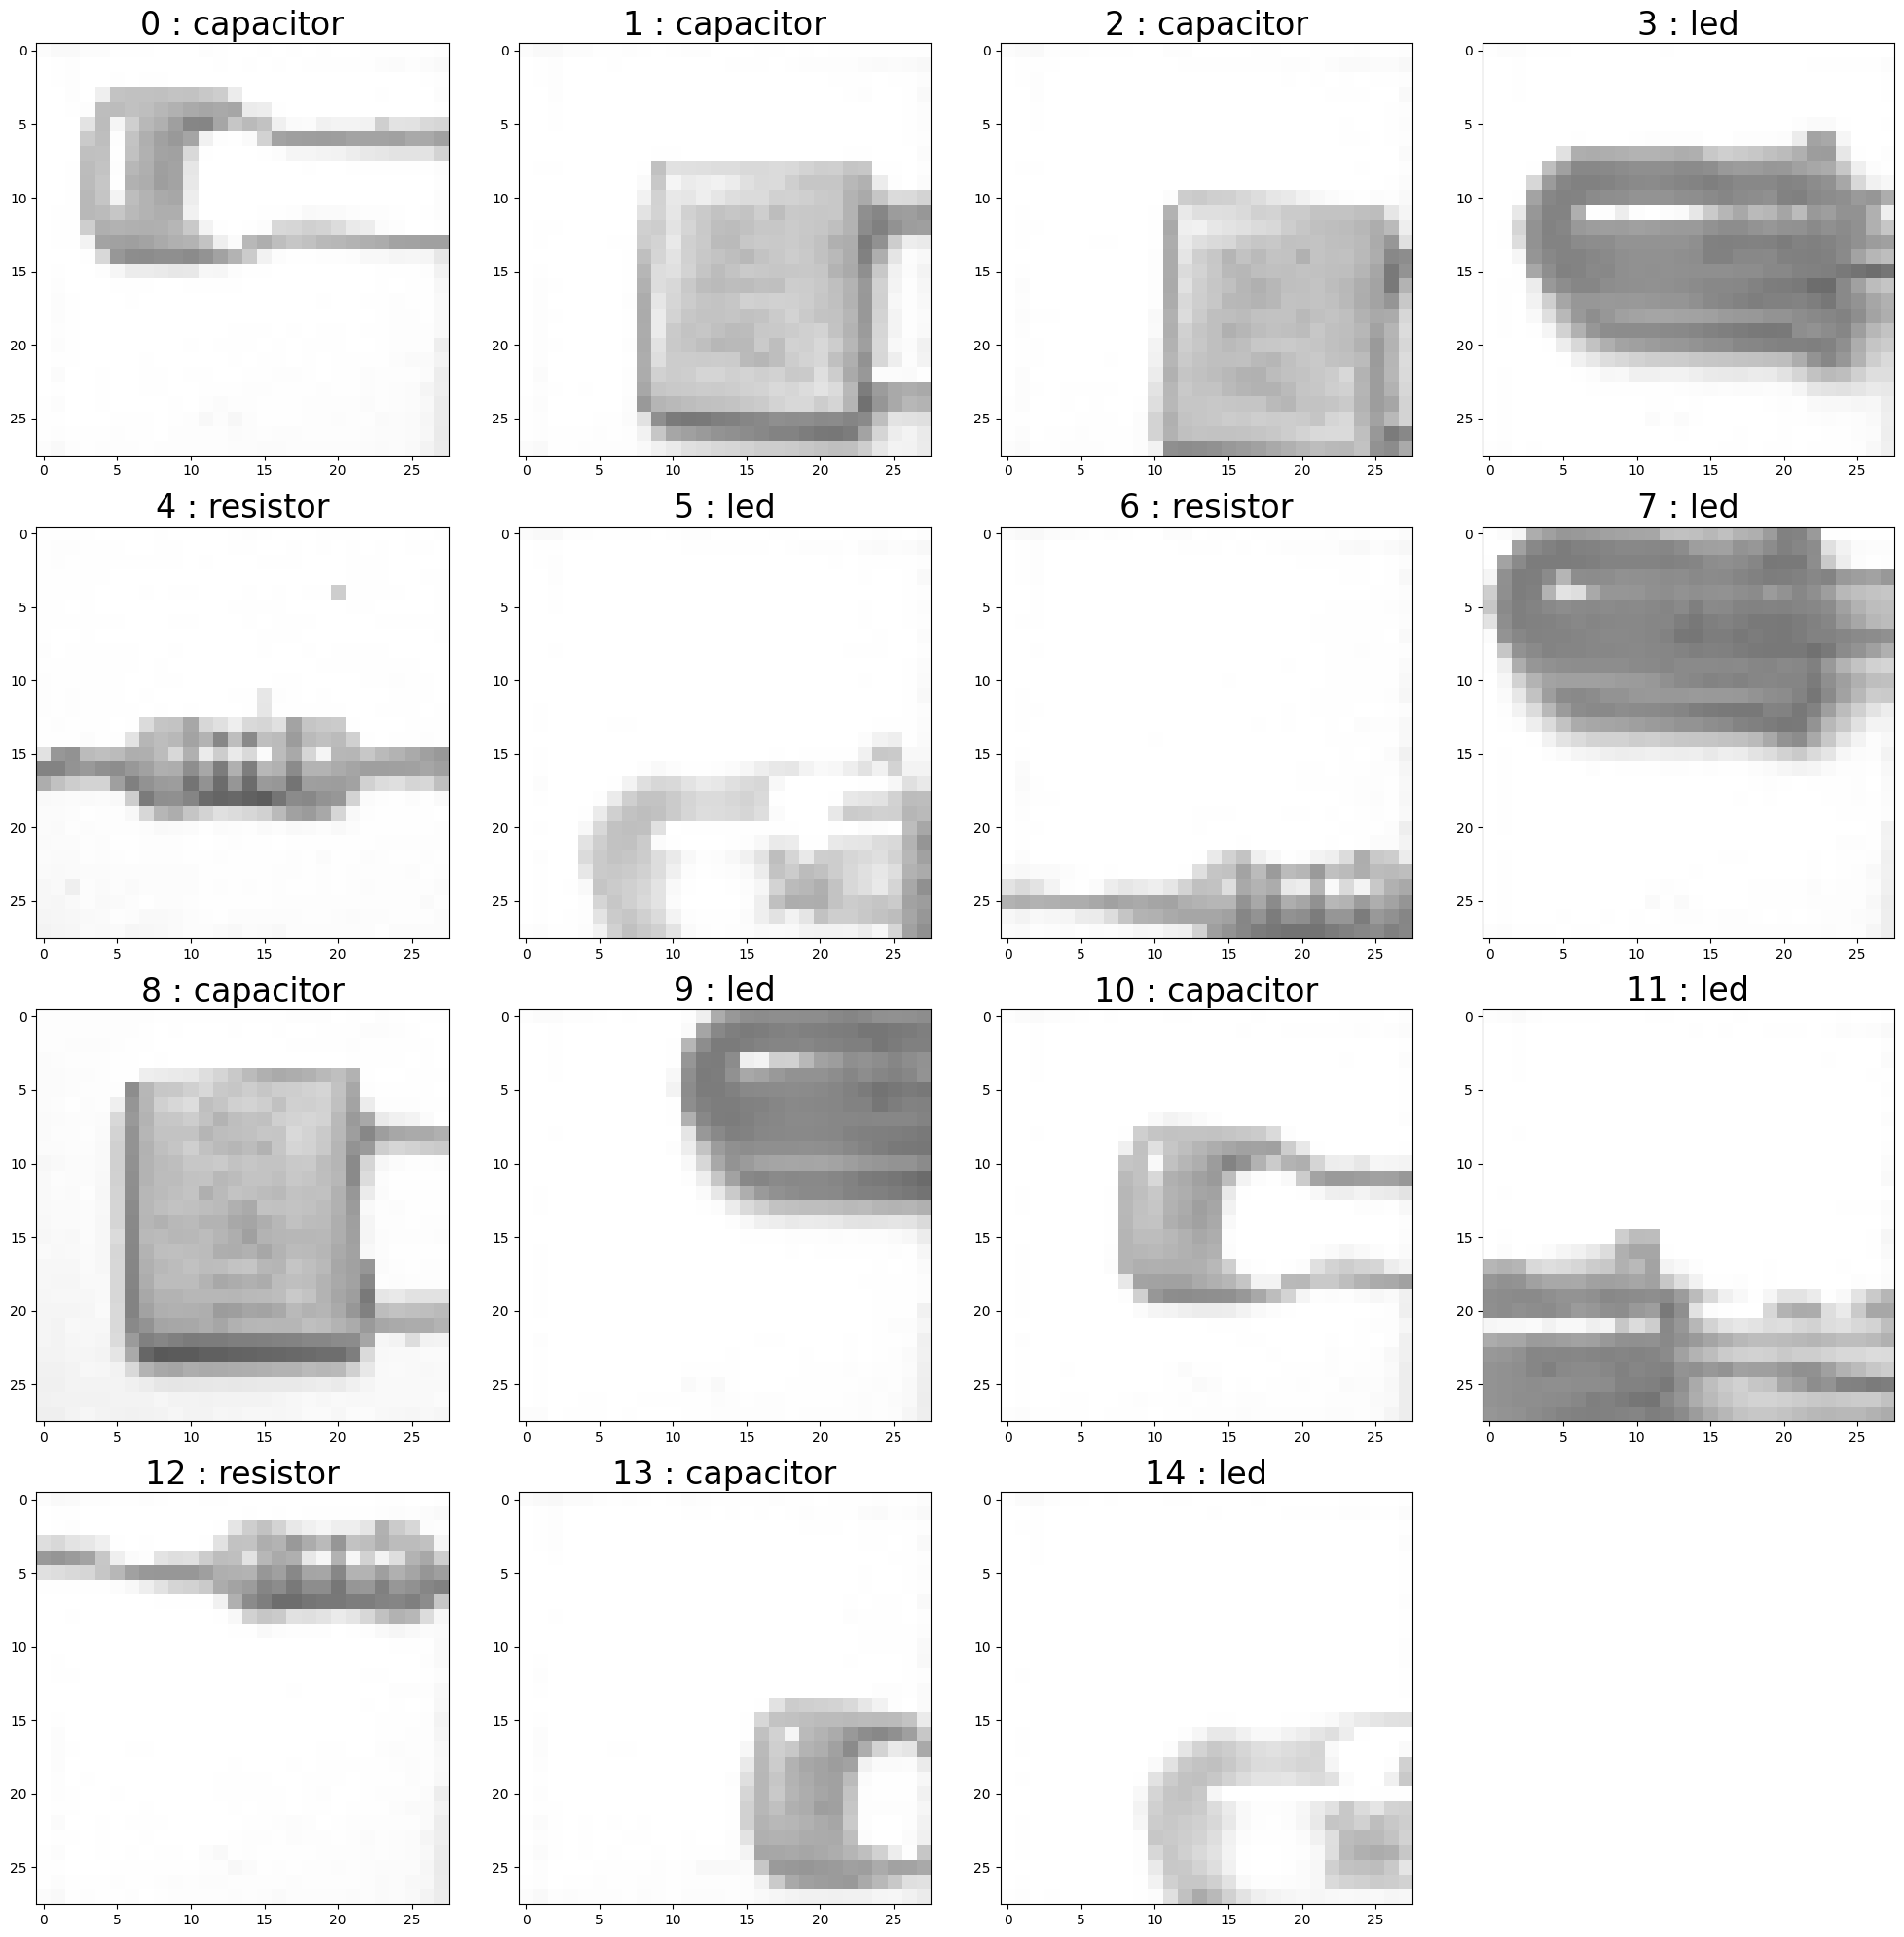

In [308]:
# show all sample images in a square grid

# calculate side of square grid and create figure of size n * n
n = np.ceil(np.sqrt(len(imgs_normalized)))
fig = plt.figure(figsize = (n * 5.0, n * 5.0), dpi = 100)

for i, img in enumerate(imgs_normalized):
  ax = fig.add_subplot(n, n, i + 1)
  ax.imshow(imgs_normalized[i], cmap='gray', vmin=0.0, vmax=1.0)
  # set title of format '<sample-nr, class>' (assumes sample images names are in format <class>-<some class-unique id>)
  ax.set_title('%d : %s' % (i, labels[true_label_idx[i]]), fontsize = 24)

fig.tight_layout()

# save images for display (as .png)
plt.savefig(os.path.join(output_img_dir, ("sample-images.png")), bbox_inches = 'tight', format = 'png')


In [309]:
### reshape input features according to expected model input shape

# we assume one of two input shapes : 
# - sequential model (DNN) : (1, height * width) shape 
# - non-sequential model (CNN) : (1, height, width, 1) shape
def reshape_features(img_list, model_type = 'cnn'):

  features = []

  for i, img in enumerate(img_list):

    img_reshaped = np.array(None)

    if model_type == 'cnn':
      img_reshaped = np.reshape(img, (height, width))
      img_reshaped = img_reshaped.reshape(img_reshaped.shape + (1,))
      # keras expects more than one image (in Numpy array), so convert image(s) to such array
      img_reshaped = np.array([img_reshaped])

    elif model_type == 'dnn':
      img_reshaped = img.reshape(1, img.shape[0] * img.shape[1])

    features.append(img_reshaped)

  return features


In [319]:
### do a forward pass (inference) with the test images and print the predicted probabilities

# set float display precision to 5 decimal places
pd.options.display.float_format = '{:,.5f}'.format

predictions = []

# adjust shape of input features to model under test 
model_type = ''
if tuple(1 if x is None else x for x in model.input_shape) == (1, height * width):
  model_type = 'dnn'
else:
  model_type = 'cnn'

input_features = reshape_features(imgs_normalized, model_type)

for i, features in enumerate(input_features):

  # inference
  preds = model.predict(features)
  # save predictions in table format
  prediction_row = {}
  prediction_row['sample'] = i
  for i, pred in enumerate(preds[0]):
    prediction_row[labels[i]] = pred
  # append to predictions list
  predictions.append(prediction_row)

# convert predictions list to data frame
predcitions_table = pd.DataFrame(predictions)
# add expected label
predcitions_table['expected'] = predcitions_table['sample'].apply(lambda x : labels[true_idx[x]])
# add predicted label + 'ok' / 'not ok' column
predcitions_table['predicted'] = predcitions_table[labels].idxmax(axis = 1)
predcitions_table['ok?'] = (predcitions_table['predicted'] == predcitions_table['expected']).astype(int)

display(predcitions_table)


,sample,background,capacitor,led,resistor,expected,predicted,ok?
0,0,0.00000,0.95827,0.03739,0.00434,capacitor,capacitor,1
1,1,0.00000,0.28614,0.71386,0.00000,capacitor,led,0
2,2,0.00000,0.37201,0.62799,0.00000,capacitor,led,0
3,3,0.00000,0.01162,0.98838,0.00000,led,led,1
4,4,0.00000,0.00000,0.00000,1.00000,resistor,resistor,1
5,5,0.00003,0.00185,0.99658,0.00154,led,led,1
6,6,0.00000,0.00026,0.00990,0.98984,resistor,resistor,1
7,7,0.00000,0.90751,0.09249,0.00000,led,capacitor,0
8,8,0.00000,1.00000,0.00000,0.00000,capacitor,capacitor,1
9,9,0.00000,0.86128,0.13871,0.00000,led,capacitor,0


In [311]:
### For either algorithm, we need to remove the Softmax activation function of the last layer
model.layers[-1].activation = None


## Saliency Map

In [312]:
### Based on: https://github.com/keisen/tf-keras-vis/blob/master/tf_keras_vis/saliency.py
def get_saliency_map(img_array, model, class_idx, model_type = 'cnn', reshape_size = None):

  # Gradient calculation requires input to be a tensor
  img_tensor = tf.convert_to_tensor(img_array)

  # Do a forward pass of model with image and track the computations on the "tape"
  with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:

    # Compute (non-softmax) outputs of model with given image
    tape.watch(img_tensor)
    outputs = model(img_tensor, training=False)

    # Get score (predicted value) of actual class
    score = outputs[:, class_idx]

  # Compute gradients of the loss with respect to the input image
  grads = tape.gradient(score, img_tensor)

  # Reshape gradients output (necessary if model type is sequential, i.e. 'dnn')
  if model_type == 'dnn':
    # reshape to (height, width) format
    grads = np.reshape(grads, reshape_size)
    # add color channel
    grads = grads.reshape(grads.shape + (1,))
    grads = np.array([grads])

  # Finds max value in each color channel of the gradient (should be grayscale for this demo)
  grads_disp = [np.max(g, axis=-1) for g in grads]

  # There should be only one gradient heatmap for this demo
  grad_disp = grads_disp[0]

  # The absolute value of the gradient shows the effect of change at each pixel
  # Source: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html
  grad_disp = tf.abs(grad_disp)

  # Normalize to between 0 and 1 (use epsilon, a very small float, to prevent divide-by-zero error)
  heatmap_min = np.min(grad_disp)
  heatmap_max = np.max(grad_disp)
  heatmap = (grad_disp - heatmap_min) / (heatmap_max - heatmap_min + tf.keras.backend.epsilon())

  return heatmap.numpy()


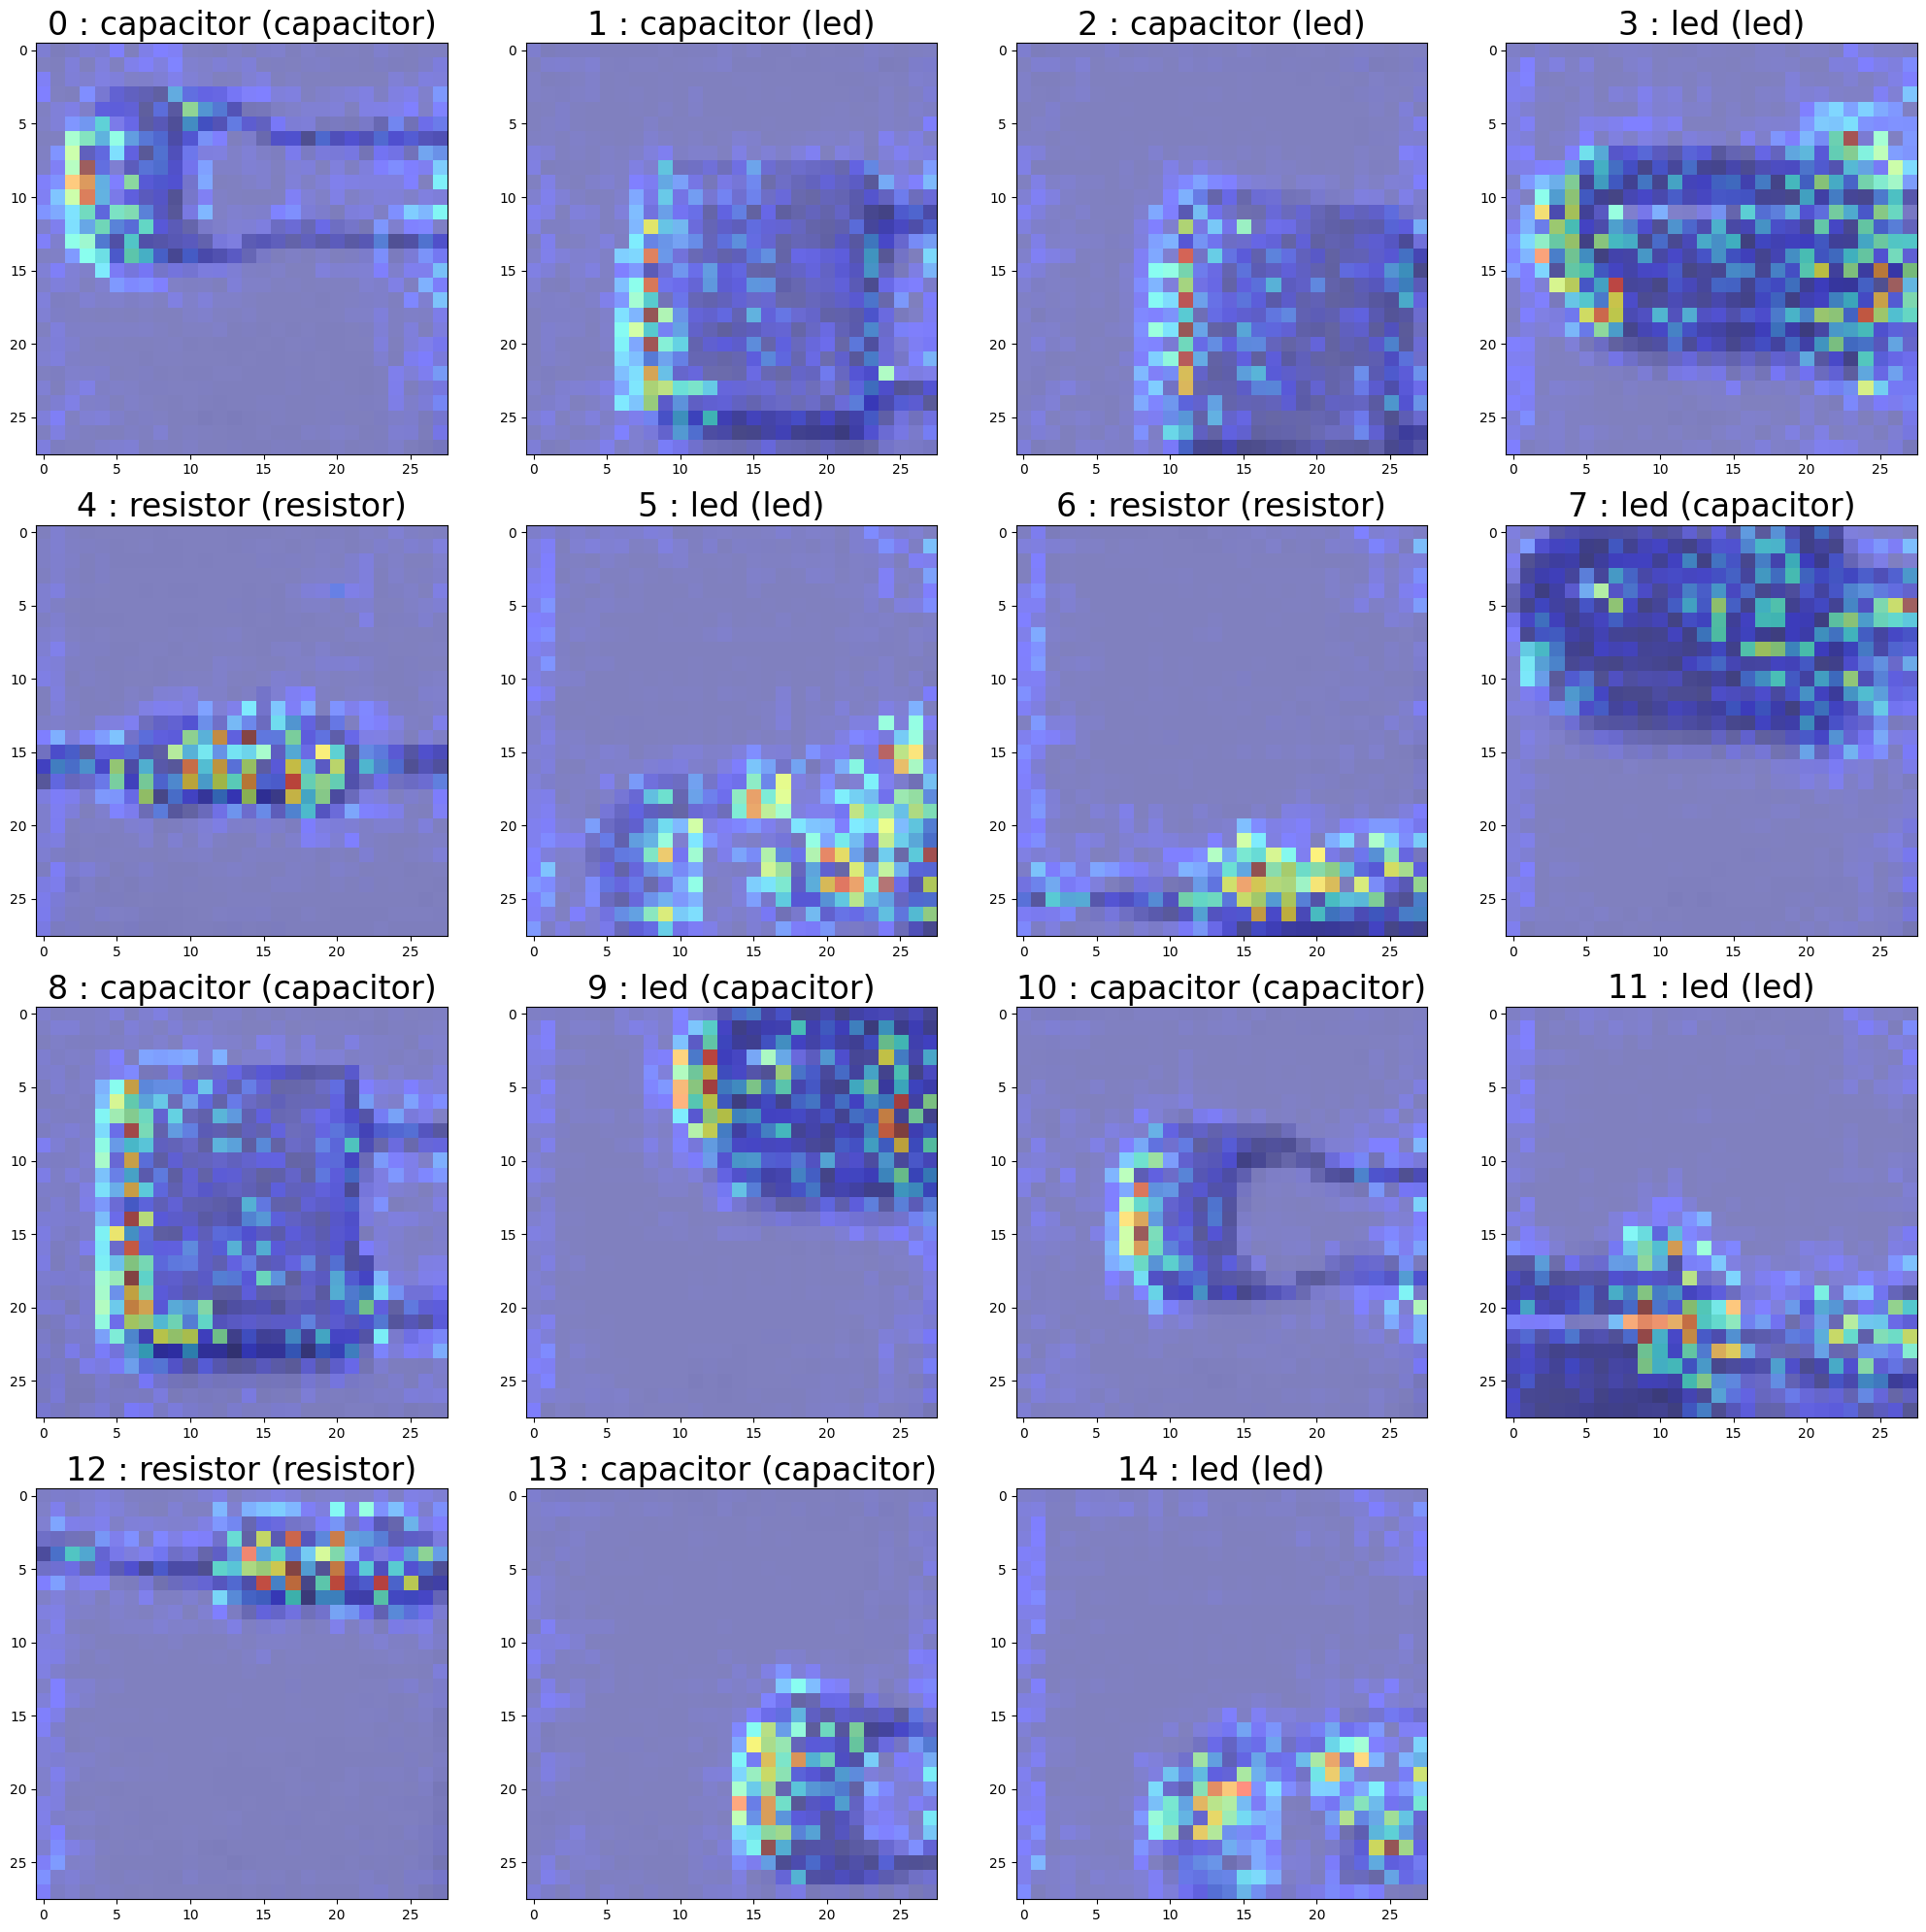

In [313]:
### generate saliency maps for the sample images

n = np.ceil(np.sqrt(len(input_features)))
fig = plt.figure(figsize = (n * 5.0, n * 5.0), dpi = 100)

for i, img in enumerate(input_features):
  ax = fig.add_subplot(n, n, i + 1)
  saliency_map = get_saliency_map(img, model, true_label_idx[i], model_type, reshape_size = (height, width))
  # draw saliency map over base image
  ax.imshow(np.reshape(img, (height, width)), cmap='gray', vmin=0.0, vmax=1.0)
  ax.imshow(saliency_map, cmap='jet', alpha = 0.50 if model_type is 'cnn' else .25)
  ax.set_title('%d : %s (%s)' % (i, labels[true_label_idx[i]], predcitions_table.iloc[i]['predicted']), fontsize = 24)

fig.tight_layout()

# save images for display (as .png)
plt.savefig(os.path.join(output_img_dir, ("saliency-maps-%s.png" % (model_type))), bbox_inches = 'tight', format = 'png') 


## Grad-CAM

Since generating GRAD-CAMs requires convolutional layers by definition, this will not work for models of type 'dnn'.

In [314]:
### This function comes from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # The absolute value of the gradient shows the effect of change at each pixel
  # Source: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html
  heatmap = tf.abs(heatmap)

  # Normalize to between 0 and 1 (use epsilon, a very small float, to prevent divide-by-zero error)
  heatmap_min = np.min(heatmap)
  heatmap_max = np.max(heatmap)
  heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + tf.keras.backend.epsilon())

  return heatmap.numpy()

In [315]:
### We need to tell Grad-CAM where to find the last convolution layer

# Print out the layers in the model
for layer in model.layers:
  print(layer, layer.name)

# Go backwards through the model to find the last convolution layer
last_conv_layer = None
for layer in reversed(model.layers):
    if 'conv' in layer.name:
        last_conv_layer = layer.name
        break

# Give a warning if the last convolution layer could not be found
if last_conv_layer is not None:
  print("Last convolution layer found:", last_conv_layer)
else:
  print("ERROR: Last convolution layer could not be found. Do not continue.")
  

<keras.layers.convolutional.Conv2D object at 0x7f125fdc53d0> conv2d
<keras.layers.pooling.MaxPooling2D object at 0x7f125f587150> max_pooling2d
<keras.layers.convolutional.Conv2D object at 0x7f125711e1d0> conv2d_1
<keras.layers.pooling.MaxPooling2D object at 0x7f1254183b50> max_pooling2d_1
<keras.layers.core.flatten.Flatten object at 0x7f1256cdad50> flatten
<keras.layers.core.dropout.Dropout object at 0x7f125f2d4c90> dropout
<keras.layers.core.dense.Dense object at 0x7f1254157250> y_pred
Last convolution layer found: conv2d_1


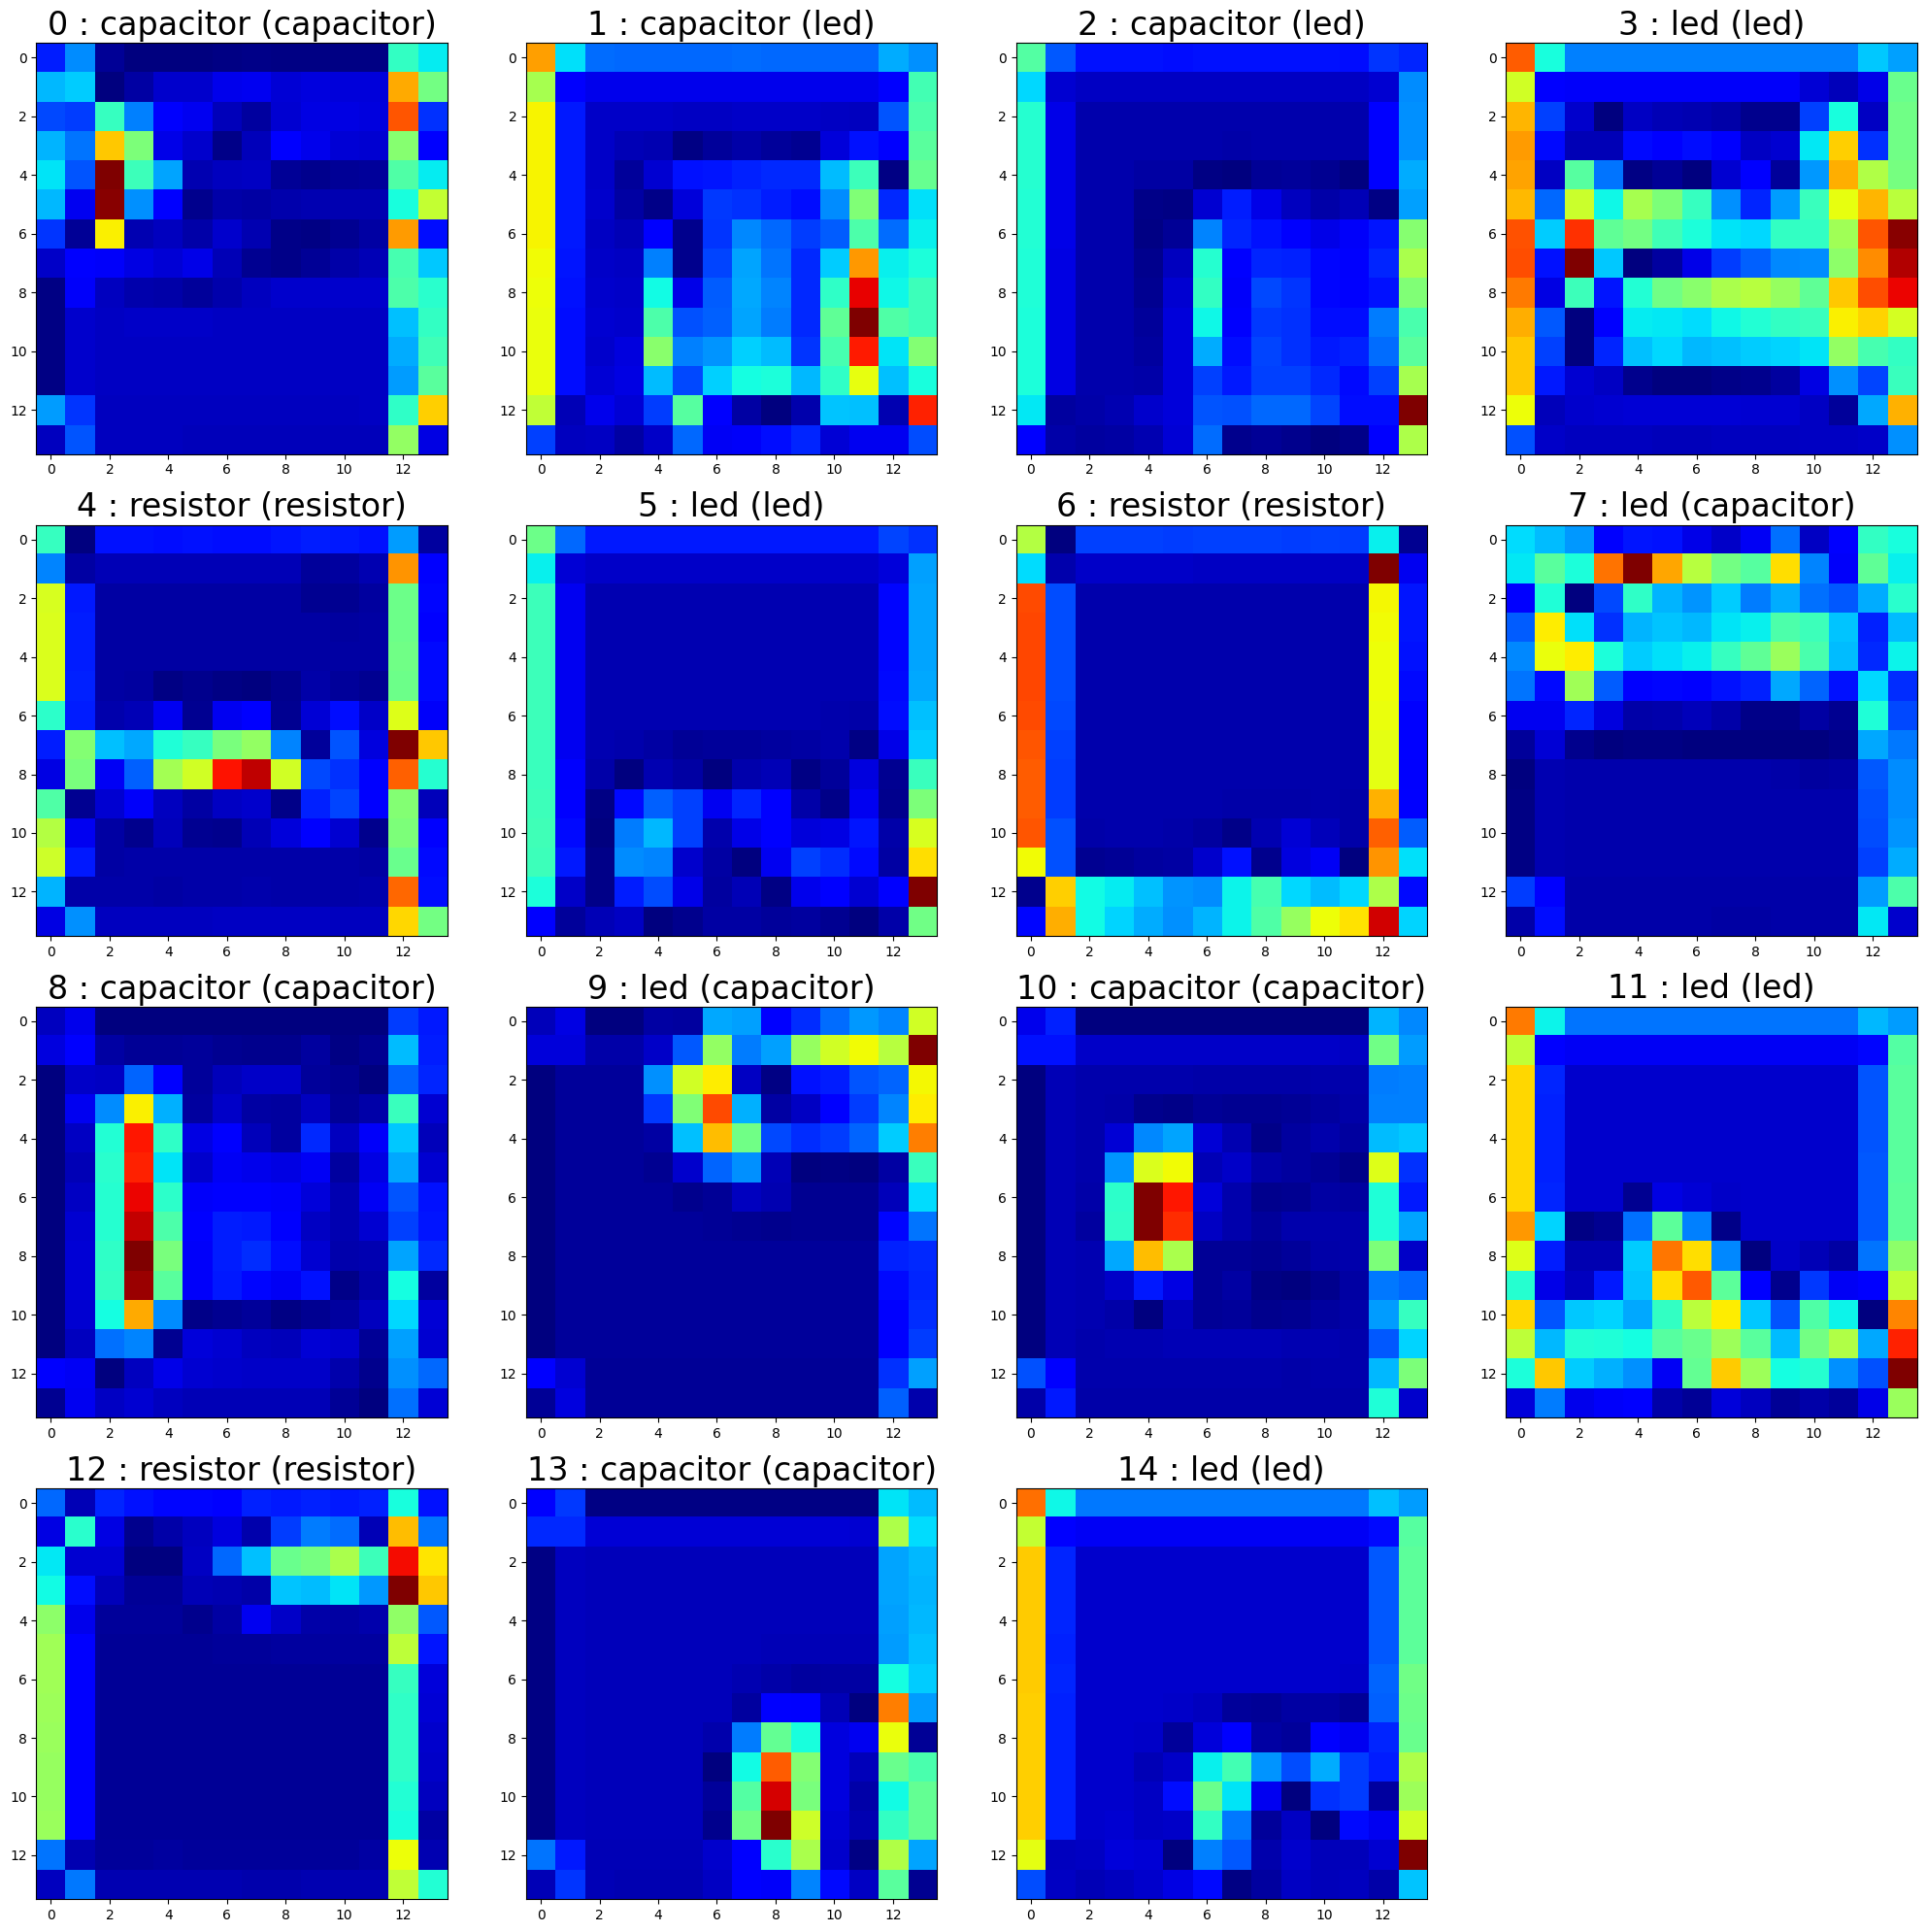

In [316]:
### generate class activation heatmaps for each sample image

n = np.ceil(np.sqrt(len(input_features)))
fig = plt.figure(figsize = (n * 5.0, n * 5.0), dpi = 100)

for i, img in enumerate(input_features):
  heatmap = make_gradcam_heatmap(img, model, last_conv_layer)
  ax = fig.add_subplot(n, n, i + 1)
  ax.imshow(heatmap, cmap='jet', vmin=0.0, vmax=1.0)
  ax.set_title('%d : %s (%s)' % (i, labels[true_label_idx[i]], predcitions_table.iloc[i]['predicted']), fontsize = 24)  

fig.tight_layout()

# save images for display (as .png)
plt.savefig(os.path.join(output_img_dir, ("grad-cam-heatmaps-%s.png" % (model_type))), bbox_inches = 'tight', format = 'png') 



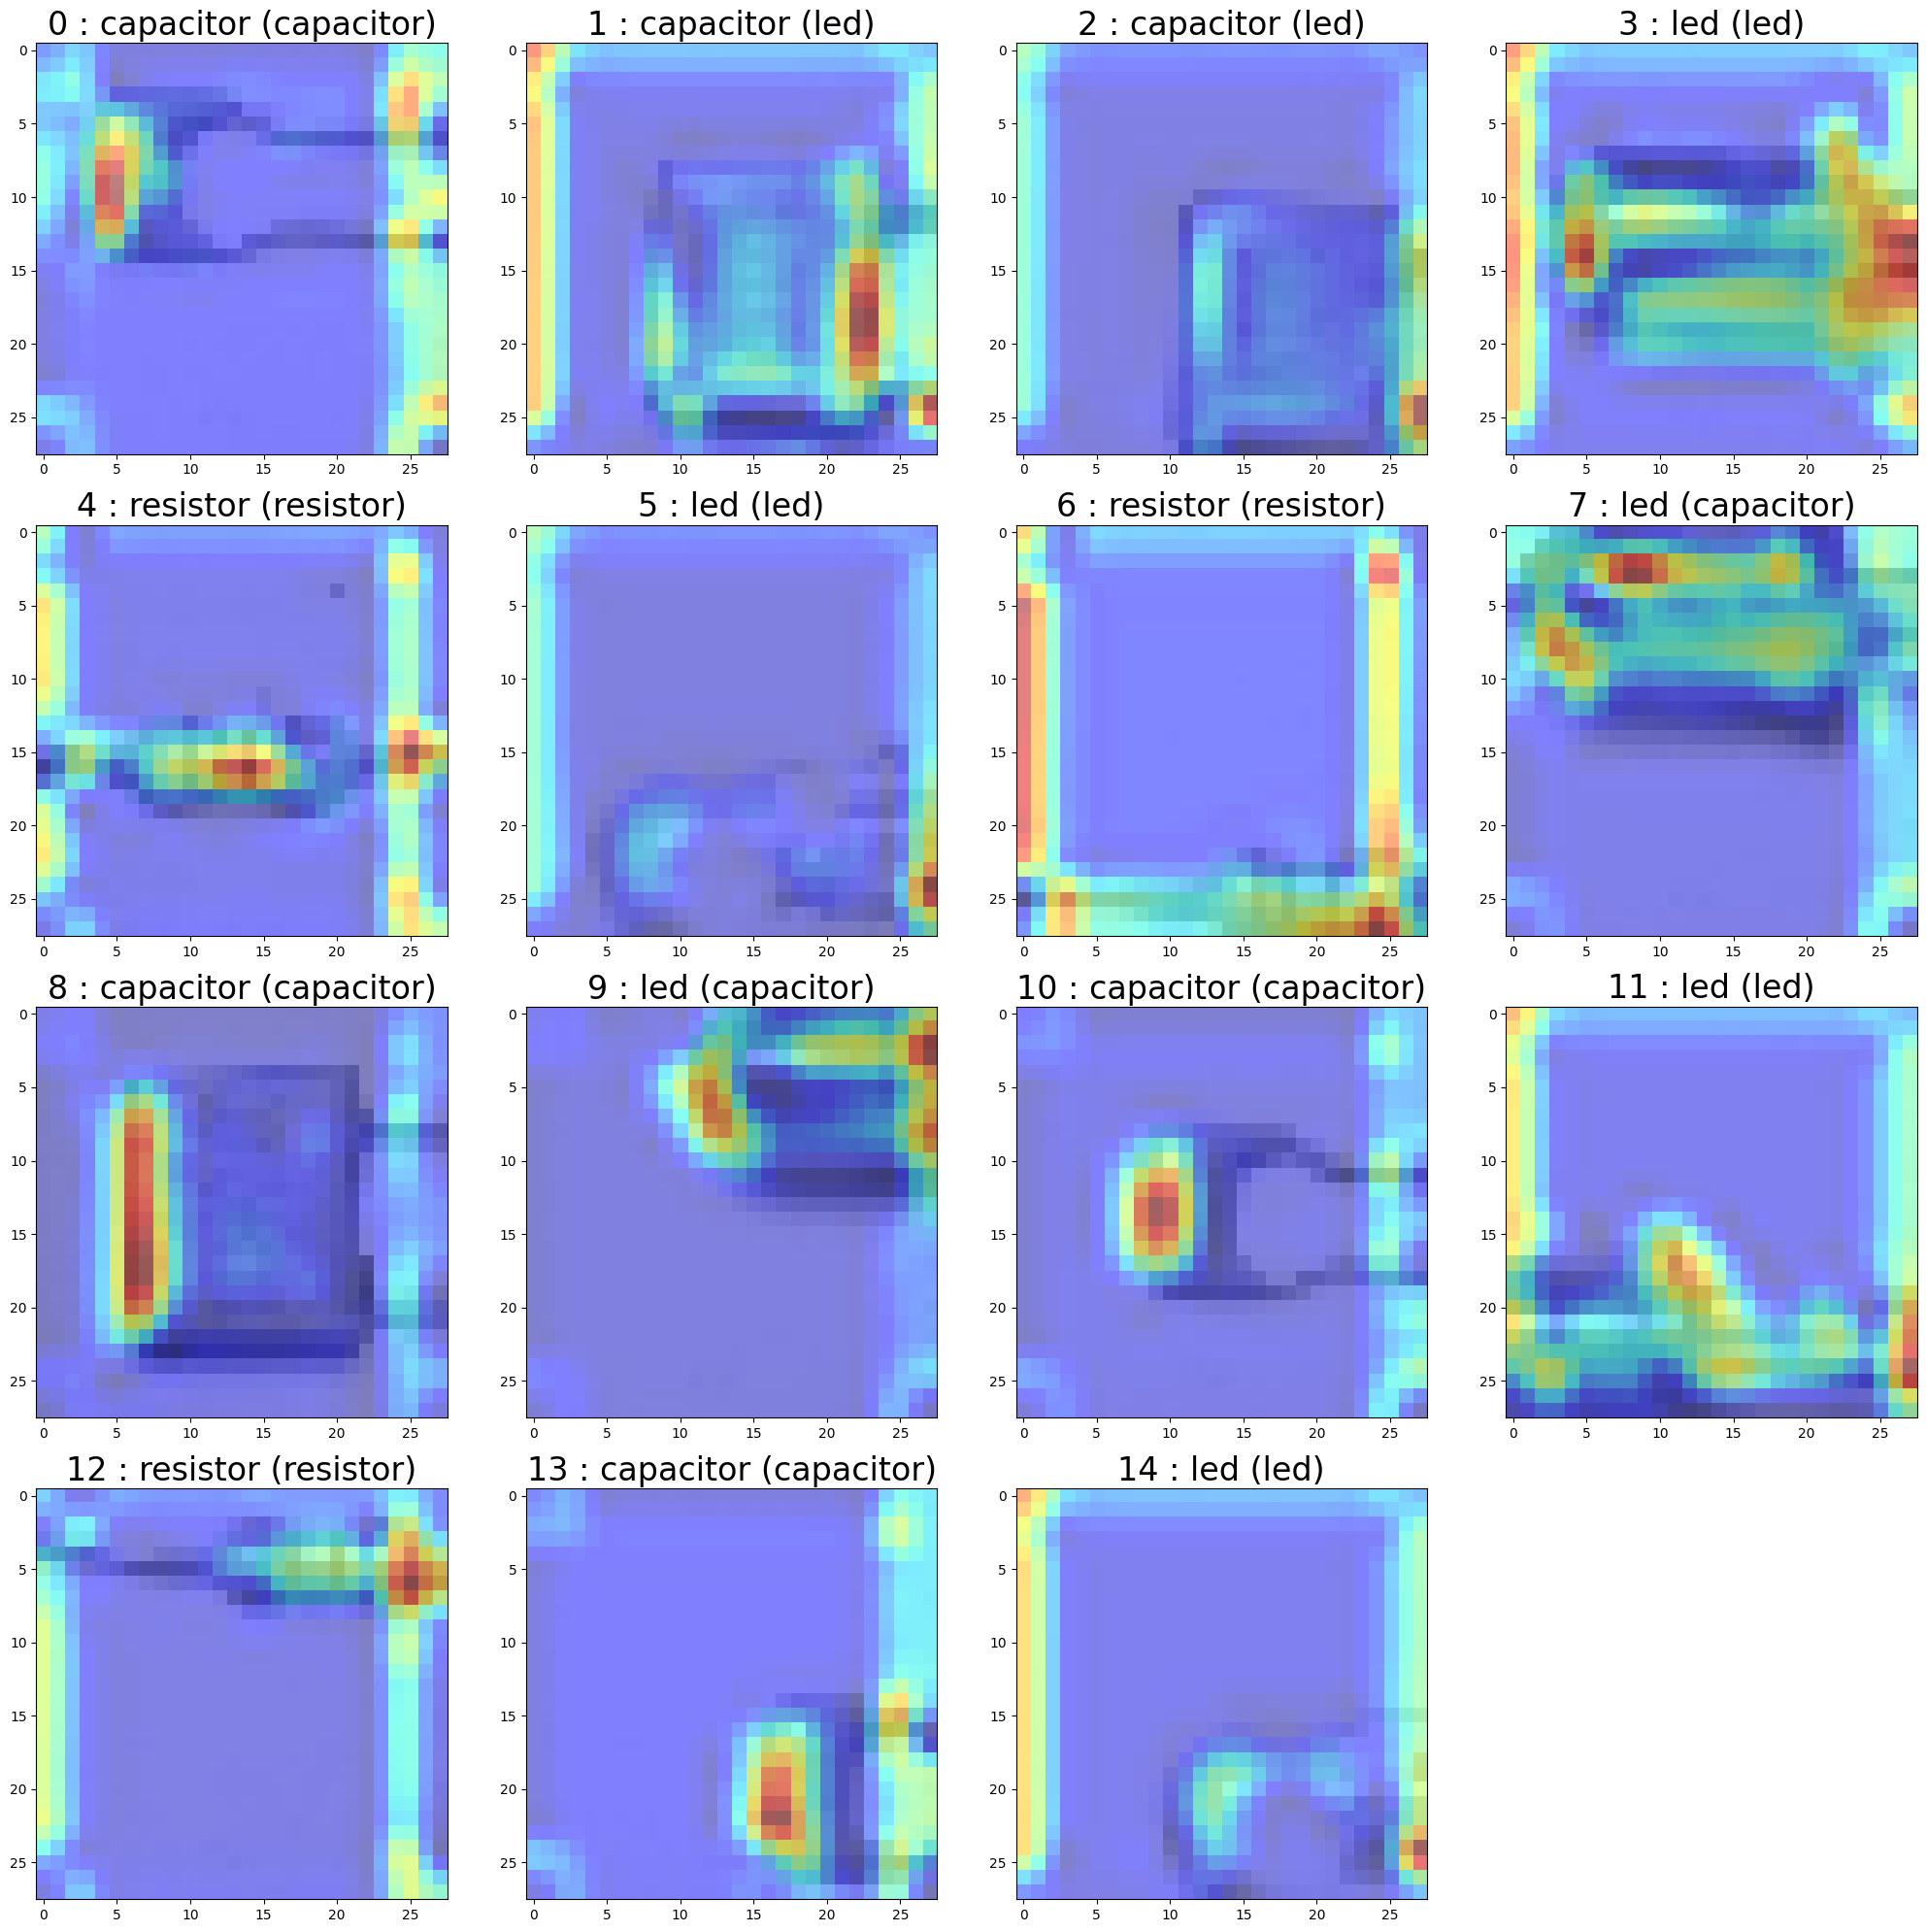

In [317]:
### overlay the GRAD-CAM on top of the original sample images

fig = plt.figure(figsize = (n * 5.0, n * 5.0), dpi = 100)

for i, img in enumerate(input_features):
  # generate class activation heatmaps for each sample image  
  heatmap = make_gradcam_heatmap(img, model, last_conv_layer)
  # heatmap is a lot smaller than the original image, so we upsample it
  big_heatmap = cv2.resize(heatmap, dsize=(height, width), interpolation=cv2.INTER_CUBIC)

  ax = fig.add_subplot(n, n, i + 1)
  ax.imshow(np.reshape(img, (height, width)), cmap='gray', vmin=0.0, vmax=1.0)
  ax.imshow(big_heatmap, cmap='jet', alpha = 0.50 if model_type is 'cnn' else .25)
  ax.set_title('%d : %s (%s)' % (i, labels[true_label_idx[i]], predcitions_table.iloc[i]['predicted']), fontsize = 24)  

fig.tight_layout()

# save images for display (as .png)
plt.savefig(os.path.join(output_img_dir, ("grad-cam-heatmaps-overlay-%s.png" % (model_type))), bbox_inches = 'tight', format = 'png') 
